In [1]:
%load_ext autoreload
%autoreload 2
import sys
from lib.base import * 
from lib.network_spill import complex_network
from lib.network_topology import MyGraph

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.cm as cm

C:\ProgramData\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 选择使用什么参数  年度/月度   评分类型

In [2]:
time_type = 'month'


CN = complex_network(time_type = time_type)

df_hz_esg = CN.get_hz_esg_data(time_type)

if time_type == 'month':
    day_month_pairs = [(1, 31), (4, 30), (7, 31), (10, 31)]
    start_year = 2013
    end_year = 2023
    generated_dates = generate_dates(start_year, end_year, day_month_pairs)
    time_list = generated_dates.copy()
if time_type == 'year':
    time_list = range(2013,2024)
    
score_type = 'esg_score'
#score_type = 'esg_quantile'
#quantile_num = 5



# 方差分解两两的热力图

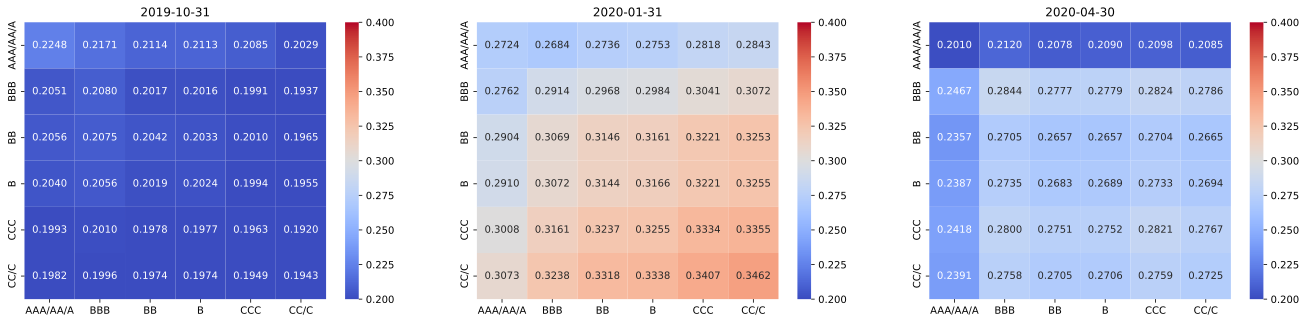

In [10]:


def get_heatmap_spil(df_hz_esg, time_type = 'year'):
    
    #analisys_months = [datetime.date(2019,7,31), datetime.date(2019,10,31), datetime.date(2020,1,31),datetime.date(2020,4,30), datetime.date(2020,7,31), datetime.date(2020,10,31),]
    #df_hz_esg = CN.get_hz_esg_data(time_type)

    if time_type == 'month':
        # 分析事件的前中后
        analysis_list = [datetime.date(2019,10,31), datetime.date(2020,1,31), datetime.date(2020,4,30)]
        #analysis_list = [datetime.date(2015,1,31), datetime.date(2015,7,31), datetime.date(2016,1,31)]

        #analysis_list = [datetime.date(2014,1,31),datetime.date(2015,1,31), datetime.date(2016,1,31), datetime.date(2017,1,31), datetime.date(2018,1,31), datetime.date(2019,1,31),]
        #analysis_list = [datetime.date(2014,1,31), datetime.date(2014,4,30),datetime.date(2015,4,30), datetime.date(2016,4,30), datetime.date(2017,4,30), datetime.date(2018,4,30), datetime.date(2019,4,30),]
        #analysis_list = generated_dates[4:16]
        if len(analysis_list) ==3 :
            fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(23, 5))
        #fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(23, 5))
        #fig, ((ax1, ax2, ax3), (ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(22, 12))

    if time_type == 'year':
        # 分析全部的历史
        analysis_list = range(2015,2024)
        #fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(23, 5))
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(22, 12))

    for num, i in enumerate(analysis_list):

        if time_type == 'year':
            df_hz_esg_i = df_hz_esg[df_hz_esg['年份'] == i]
        if time_type == 'month':
            df_hz_esg_i = df_hz_esg[pd.to_datetime(df_hz_esg['评级日期']).dt.date == i]

        df = pd.read_csv('output/esg_fevd_{0}/{1}.csv'.format(time_type, i))
        df.code = df.code.apply(pad_stock_code)
        df = df.set_index(df.code)
        df = df.drop(['code'], axis =1 )

        #合并两个矩阵的交集
        intersection = list(set(df.index.tolist()).intersection(set(df_hz_esg_i.index.tolist())))
        df = df.loc[intersection, intersection]
        df_hz_esg_i = df_hz_esg_i.loc[intersection]


        #rate_list = [['AAA/AA/A'], ['BBB'], ['BB'], ['B'], ['CCC'], ['CC/C']]
        rate_list = [['AAA', 'AA', 'A'], ['BBB'], ['BB'], ['B'], ['CCC'], ['CC', 'C']]

        j = rate_list[0]

        ns_list = {}
        for k in rate_list:
            ns_list[str(k).replace('[', '').replace(']', '')] = {}
            for n in rate_list:
                rate_j_list1 = np.array(df_hz_esg_i[df_hz_esg_i['综合评级'].isin(k)].index.tolist())
                rate_j_list2= np.array(df_hz_esg_i[df_hz_esg_i['综合评级'].isin(n)].index.tolist())

                df3 = df.loc[rate_j_list1 , rate_j_list2]
                df4 = df.loc[rate_j_list2 , rate_j_list1]

                ns_list[str(k).replace('[', '').replace(']', '')][str(n).replace('[', '').replace(']', '')] = df3.sum().sum() / (df3.size)

        ns_list = pd.DataFrame(ns_list)
        #sns.heatmap(ns_list, annot=True, ax = eval('ax%s'%(num+1)), cmap='YlGnBu', fmt='.4f')
        vmin = 0.2
        vmax = 0.4
        ns_list.columns = ['AAA/AA/A', 'BBB', 'BB', 'B', 'CCC', 'CC/C']
        ns_list.index = ['AAA/AA/A', 'BBB', 'BB', 'B', 'CCC', 'CC/C']

        sns.heatmap(ns_list, annot=True, ax=eval('ax%s' % (num + 1)), cmap='coolwarm', fmt='.4f',vmin=vmin, vmax=vmax)

        eval('ax%s'%(num+1)).set_title(i)


    #plt.xlabel('Rating List')
    #plt.ylabel('Rating List')
    plt.savefig('pics/evfd_%s_2020.jpg'%time_type)
    
    
get_heatmap_spil(df_hz_esg, time_type = 'month')




# sns.heatmap(ns_list, annot=True, ax=eval('ax%s' % (num + 1)), cmap='coolwarm', fmt='.4f')
# plt.show()

# from matplotlib.colors import LinearSegmentedColormap

# custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#2c7bb6', '#ffffbf', '#d7191c'])

# # 绘制热力图，使用自定义配色方案
# sns.heatmap(ns_list, annot=True, ax=eval('ax%s' % (num + 1)), cmap=custom_cmap, fmt='.4f')

# # 设置标题
# eval('ax%s' % (num + 1)).set_title(i)

# # 显示图像
# plt.show()

In [4]:
def get_node_edge(time_type ='month', month_ = '2020-01-31'):

    #time_type = 'month'
    df = pd.read_csv('output/esg_fevd_{0}/{1}.csv'.format(time_type, month_))
    df.code = df.code.apply(pad_stock_code)
    df = df.set_index(df.code)
    df = df.drop(['code'], axis =1 )

    df = df.iloc[:1000,:1000]

    df_hz_esg_i = df_hz_esg[pd.to_datetime(df_hz_esg['评级日期']).dt.date == datetime.datetime.strptime(month_, '%Y-%m-%d').date()]
    threshold = df[df != 0].stack().quantile(0.9)

    edges = df.stack().reset_index()
    edges.columns = ['Source', 'Target', 'Weight']
    edges_sparse = edges[(edges['Weight'] >= threshold) & (edges['Source'] != edges['Target'])]
    df_hz_esg_i_me = df_hz_esg_i[['综合评级']]
    df_hz_esg_i_me.index.name = 'Source'
    edges_sparse = pd.merge(edges_sparse, df_hz_esg_i_me, on = 'Source', how = 'left')
    edges_sparse.columns = ['Source', 'Target', 'Weight', 'Group']
    nodes = pd.DataFrame({
        'ID': df.columns,
        'Label': df.columns
    })
    df_hz_esg_i_me.index.name = 'ID'
    nodes = pd.merge(nodes, df_hz_esg_i_me, on = 'ID', how = 'left')
    nodes.columns = ['ID', 'Label', 'Group']
    
    #nodes.to_csv('tex/nodes_sparse.csv', index=False)

    # 导出稀疏化后的边表
    #edges_sparse.to_csv('tex/edges_sparse.csv', index=False)
    return nodes, edges_sparse
    

In [5]:
df_output = pd.DataFrame()

## 2.4.1  Spillover Strengh 

  0%|          | 0/44 [00:00<?, ?it/s]

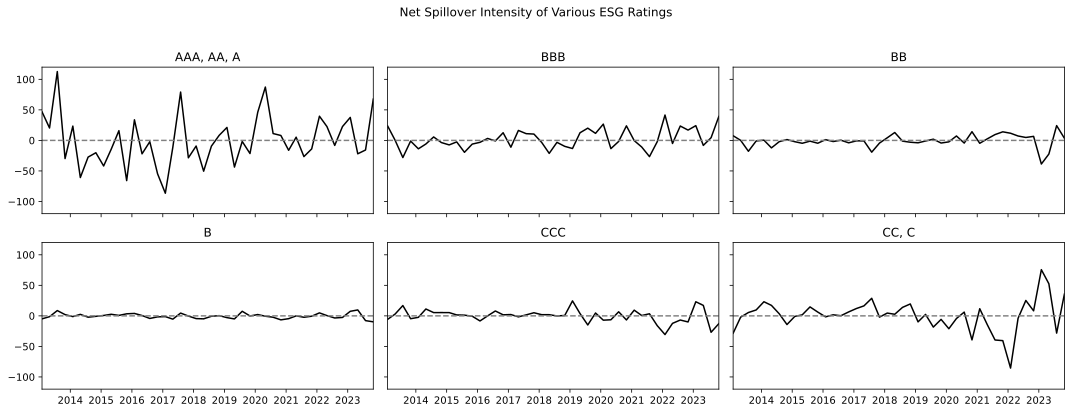

In [6]:
day_month_pairs = [(1, 31), (4, 30), (7, 31), (10, 31)]
start_year = 2013
end_year = 2023
generated_dates = generate_dates(start_year, end_year, day_month_pairs)
time_list = generated_dates.copy()


df_is = pd.DataFrame()
df_os = pd.DataFrame()
df_ns = pd.DataFrame()

for i in tqdm(time_list):
    df = pd.read_csv('output/esg_fevd_{0}/{1}.csv'.format(time_type, i))
    df.code = df.code.apply(pad_stock_code)
    df = df.set_index(df.code)
    df = df.drop(['code'], axis =1 )
    np.fill_diagonal(df.values, 0)
    IS = df.sum(axis = 0)
    OS = df.sum(axis =1)
    NS = OS - IS
    #print (NS)
    IS, OS, NS
    #df_hz_esg_i = df_hz_esg[df_hz_esg['年份'] == month_]
    df_hz_esg_i = df_hz_esg[pd.to_datetime(df_hz_esg['评级日期']).dt.date == i]

    df_hz_esg_i = df_hz_esg_i.loc[df.columns]
    if score_type == 'esg_score':
        df_hz_esg_i.loc[:,'rating_score'] = df_hz_esg_i['综合评级']
        rate_list = [['AAA', 'AA', 'A'], ['BBB'], ['BB'], ['B'], ['CCC'], ['CC', 'C']]

    if score_type == 'esg_quantile':
        df_hz_esg_i.loc[:,'rating_score'] = pd.qcut(df_hz_esg_i['综合得分'], q=quantile_num, labels=[f'Q{i+1}' for i in range(quantile_num)])
        rate_list = [f'Q{i+1}' for i in range(quantile_num)]
    is_list = []
    os_list = []
    ns_list = []
    
    for j in rate_list:
        
        if type(j) == list:
            rate_j_list = df_hz_esg_i[df_hz_esg_i['rating_score'].isin(j)].index.tolist()
        if type(j) == str:
            rate_j_list = df_hz_esg_i[df_hz_esg_i['rating_score'] == j].index.tolist()

        #print (j, IS[IS.index.isin(rate_j_list)].mean(), OS[OS.index.isin(rate_j_list)].mean(), NS[NS.index.isin(rate_j_list)].mean())
        
        is_list.append(IS[IS.index.isin(rate_j_list)].mean())
        os_list.append(OS[OS.index.isin(rate_j_list)].mean())
        ns_list.append(NS[NS.index.isin(rate_j_list)].mean())
    df_is = pd.concat([df_is, pd.Series(is_list)], axis =1 )
    df_os = pd.concat([df_os, pd.Series(os_list)], axis = 1)
    df_ns = pd.concat([df_ns, pd.Series(ns_list)], axis =1 )
    
df_is.columns = time_list
df_os.columns = time_list
df_ns.columns = time_list
#df_ns.index = np.array(rate_list)

if type(rate_list[0]) == list:
    rate_list_str = [", ".join(sublist) for sublist in rate_list]
else:
    rate_list_str = rate_list.copy()
df_ns.index = np.array(rate_list_str)

df = df_ns.T

if len(rate_list) == 9:
    fig, axs = plt.subplots(3, 3, figsize=(15, 6), sharex=True, sharey=True)
if len(rate_list) <= 6:
    fig, axs = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)
    
fig.suptitle('Net Spillover Intensity of Various ESG Ratings')



#titles = ['ESG', 'Bond', 'Interbank', 'FX']
titles = df.columns
for ax, title in zip(axs.ravel(), titles):
    ax.plot(df.index, df[title], color='black')
    #ax.bar(df.index, df[title], color='black', width=20)

    ax.set_title(title)
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_xlim(df.index[0], df.index[-1])
    ax.set_ylim(-120, 120)

for ax in axs.flat:
    ax.label_outer()

#fig.text(0.5, 0.04, 'Time', ha='center')
#fig.text(0.04, 0.5, 'Return Spillovers', va='center', rotation='vertical')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.show()
plt.savefig('pics/spillover_time_series.jpg')

In [7]:
time_list

date_str = time_list[-1].strftime("%Y-%m-%d")
date_str


plt.figure(figsize=(18, 8))
sns.heatmap(result, annot=True, cmap='YlGnBu', cbar=True)

NameError: name 'result' is not defined

<Figure size 1800x800 with 0 Axes>

In [ ]:
time_list

In [ ]:
def cal_mean_max(x):
    return np.mean(eval(x)) / np.max(eval(x))



# 表4
ana_year = 2020



for ana_month in time_list:
    #try:
    #ana_month = ana_month.strftime("%Y-%m-%d")
    #ana_month = '2023-01-31'
    df_2020 = pd.read_csv('output/topological_properties_month/esg_score/%s.csv'%ana_month, index_col = 0)
    #df_2020 = df_2020.applymap(list_to_mean)
    #df_2020['中介中心性'] = 2*df_2020['中介中心性'] / (df_2020['节点数']-1) /(df_2020['节点数']-2)



    df_b4 = df_2020[['节点数', '边数','是否加权','接近中心性','特征向量中心性','平均路径长度', 'acs','信息熵']]

    df_b4['接近中心性'] = df_2020['接近中心性'].apply(cal_mean_max)
    df_b4['特征向量中心性'] = df_2020['特征向量中心性'].apply(list_to_mean)

    df_b4.to_csv('tex/b4/%s.csv'%ana_month)

    df_b4.to_latex('tex/b4/%s.tex'%ana_month)
    # except:
    #     pass

# # 表5
# df_2020
df_b5 = df_2020[['网络直径','acs', '信息熵']]
# df_b5.to_latex('tex/b5.tex')
# 替换符号
score_list = [i.replace('[','').replace(']','') for i in df_b5.index.tolist()]
score_list

df_b4.index = score_list 
#df_b5.index = score_list

df_b4.to_csv('tex/b4.csv')
#df_b5.to_csv('tex/b5.csv')

In [ ]:
# 生成表7

In [ ]:
time_list = ['2015-01-31',  '2015-07-31','2016-01-31']
time_list = ['2019-10-31', '2020-01-31', '2020-04-30']


df_cc = pd.DataFrame()
df_bc = pd.DataFrame()
df_ec = pd.DataFrame()
df_aspl = pd.DataFrame()
df_acs = pd.DataFrame()
df_entropy = pd.DataFrame()

for i in time_list:
    df_t = pd.read_csv('output/topological_properties_month/esg_score/{0}.csv'.format(i))
    #df_t = df_t.applymap(list_to_mean)
    df_t['接近中心性'] = df_t['接近中心性'].apply(cal_mean_max)
    df_t['特征向量中心性'] = df_t['特征向量中心性'].apply(list_to_mean)

    df_cc = pd.concat([df_cc, df_t['接近中心性']], axis =1 )
    #df_bc = pd.concat([df_bc, df_t['中介中心性']], axis =1 )
    df_ec = pd.concat([df_ec, df_t['特征向量中心性']], axis =1 )
    df_aspl = pd.concat([df_aspl, df_t['网络直径']], axis =1 )
    df_acs = pd.concat([df_acs, df_t['acs']], axis =1 )
    df_entropy = pd.concat([df_entropy, df_t['信息熵']], axis =1 )
    
    
df_cc.columns = time_list
#df_bc.columns = time_list
df_ec.columns = time_list
df_aspl.columns = time_list
df_acs.columns = time_list
df_entropy.columns = time_list

df_cc.columns = pd.MultiIndex.from_product([['cc'], df_cc.columns])
#df_bc.columns = pd.MultiIndex.from_product([['bc'], df_bc.columns])
df_aspl.columns = pd.MultiIndex.from_product([['aspl'], df_aspl.columns])
df_acs.columns = pd.MultiIndex.from_product([['acs'], df_acs.columns])
df_entropy.columns = pd.MultiIndex.from_product([['entropy'], df_entropy.columns])

result = pd.concat([df_cc, df_ec], axis=1)
result2 = pd.concat([df_aspl, df_acs, df_entropy], axis=1)

result.index = score_list
result2.index = score_list


result.to_csv('2020_2_ccbcec.csv')
result2.to_csv('2020_2_dmacsentropy.csv')

In [ ]:
result2

In [ ]:
analisys_years = [2013,2014,2015,  2016, 2017,2018]

#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

fig, ((ax1, ax2, ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(18, 6))

for num, year in enumerate(analisys_years):

    #year = 2015
    df = pd.read_csv('output/%s.csv'%year,)
    df_hz_esg_i = df_hz_esg[df_hz_esg['年份'] == year]

    df.code = df.code.apply(pad_stock_code)
    df = df.set_index(df.code)
    df = df.drop(['code'], axis =1 )

    #合并两个矩阵的交集
    intersection = list(set(df.index.tolist()).intersection(set(df_hz_esg_i.index.tolist())))
    df = df.loc[intersection, intersection]
    df_hz_esg_i = df_hz_esg_i.loc[intersection]

    rate_list = [['AAA', 'AA', 'A'], ['BBB'], ['BB'], ['B'], ['CCC'], ['CC', 'C']]
    j = rate_list[0]

    ns_list = {}
    for k in rate_list:
        ns_list[str(k).replace('[', '').replace(']', '')] = {}
        for n in rate_list:
            rate_j_list1 = np.array(df_hz_esg_i[df_hz_esg_i['综合评级'].isin(k)].index.tolist())
            rate_j_list2= np.array(df_hz_esg_i[df_hz_esg_i['综合评级'].isin(n)].index.tolist())

            df3 = df.loc[rate_j_list1 , rate_j_list2]
            df4 = df.loc[rate_j_list2 , rate_j_list1]

            ns_list[str(k).replace('[', '').replace(']', '')][str(n).replace('[', '').replace(']', '')] = df3.sum().sum() / (df3.size)

    ns_list = pd.DataFrame(ns_list)
    sns.heatmap(ns_list, annot=True, ax = eval('ax%s'%(num+1)), cmap='YlGnBu', fmt='.4f')
    eval('ax%s'%(num+1)).set_title(year)


#plt.xlabel('Rating List')
#plt.ylabel('Rating List')
plt.savefig('evfd.png')

# output to gephi

In [ ]:

def get_data_to_gephi():

    time_type = 'year'
    df = pd.read_csv('output/esg_fevd_{0}/{1}.csv'.format(time_type, '2020'))
    df.code = df.code.apply(pad_stock_code)
    df = df.set_index(df.code)
    df = df.drop(['code'], axis =1 )

    df = df.iloc[:1000,:1000]


    # # 导出节点表
    # nodes = pd.DataFrame({
    #     'ID': df.columns,
    #     'Label': df.columns
    # })
    # nodes.to_csv('tex/nodes.csv', index=False)

    # # 导出边表
    # edges = []
    # for i, source in enumerate(df.columns):
    #     for j, target in enumerate(df.index):
    #         if i != j:  # 排除对角线元素（即自环边）
    #             edges.append({
    #                 'Source': source,
    #                 'Target': target,
    #                 'Weight': df.iloc[i, j]
    #             })

    # edges_df = pd.DataFrame(edges)
    # edges_df.to_csv('tex/edges.csv', index=False)

    # print("节点和边数据已导出为 'nodes.csv' 和 'edges.csv'")


    year = 2020
    df_hz_esg_i = df_hz_esg[pd.to_datetime(df_hz_esg['评级日期']).dt.date == datetime.date(2020,1,31)]
    df_hz_esg_i

    # 计算稀疏阈值
    threshold = df[df != 0].stack().quantile(0.9)

    # 稀疏化边表：将低于阈值的元素设为零
    edges = df.stack().reset_index()
    edges.columns = ['Source', 'Target', 'Weight']
    edges_sparse = edges[(edges['Weight'] >= threshold) & (edges['Source'] != edges['Target'])]


    df_hz_esg_i_me = df_hz_esg_i[['综合评级']]
    df_hz_esg_i_me.index.name = 'Source'
    edges_sparse = pd.merge(edges_sparse, df_hz_esg_i_me, on = 'Source', how = 'left')

    #edges_sparse = pd.merge(edges_sparse, df_hz_esg_i_me, on = 'Source', how = 'left')
    edges_sparse.columns = ['Source', 'Target', 'Weight', 'Group']

    # 导出节点表（保持不变）
    nodes = pd.DataFrame({
        'ID': df.columns,
        'Label': df.columns
    })


    df_hz_esg_i_me.index.name = 'ID'

    nodes = pd.merge(nodes, df_hz_esg_i_me, on = 'ID', how = 'left')

    nodes.columns = ['ID', 'Label', 'Group']

    nodes.to_csv('tex/nodes_sparse.csv', index=False)

    # 导出稀疏化后的边表
    edges_sparse.to_csv('tex/edges_sparse.csv', index=False)

    print("稀疏化的边表已导出为 'edges_sparse.csv'")

In [ ]:
# 获取节点和边

def get_node_edge(time_type ='month', month_ = '2020-01-31'):

    #time_type = 'month'
    df = pd.read_csv('output/esg_fevd_{0}/{1}.csv'.format(time_type, month_))
    df.code = df.code.apply(pad_stock_code)
    df = df.set_index(df.code)
    df = df.drop(['code'], axis =1 )

    df = df.iloc[:1000,:1000]

    df_hz_esg_i = df_hz_esg[pd.to_datetime(df_hz_esg['评级日期']).dt.date == datetime.datetime.strptime(month_, '%Y-%m-%d').date()]
    threshold = df[df != 0].stack().quantile(0.)

    edges = df.stack().reset_index()
    edges.columns = ['Source', 'Target', 'Weight']
    edges_sparse = edges[(edges['Weight'] >= threshold) & (edges['Source'] != edges['Target'])]
    df_hz_esg_i_me = df_hz_esg_i[['综合评级']]
    df_hz_esg_i_me.index.name = 'Source'
    edges_sparse = pd.merge(edges_sparse, df_hz_esg_i_me, on = 'Source', how = 'left')
    edges_sparse.columns = ['Source', 'Target', 'Weight', 'Group']
    nodes = pd.DataFrame({
        'ID': df.columns,
        'Label': df.columns
    })
    df_hz_esg_i_me.index.name = 'ID'
    nodes = pd.merge(nodes, df_hz_esg_i_me, on = 'ID', how = 'left')
    nodes.columns = ['ID', 'Label', 'Group']
    
    #nodes.to_csv('tex/nodes_sparse.csv', index=False)

    # 导出稀疏化后的边表
    #edges_sparse.to_csv('tex/edges_sparse.csv', index=False)
    return df, nodes, edges_sparse


df_01, nodes_01, edges_sparse_01 = get_node_edge(month_ = '2020-01-31')
edges_sparse[edges_sparse[['Source','Target']].duplicated()]
df_01

In [ ]:
G = nx.Graph()
for index,row in nodes.iterrows():
    G.add_node(row['ID'], label = row['Label'], group=row['Group'])
    
    
for index, row in edges_sparse.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'], group=row['Group'])

    
    
import networkx as nx

node_type = rate_list.copy()
colors = ['blue', 'green', 'red', 'yellow', 'purple', 'orange']

node_colors = ['red', 'green', 'blue', 'yellow']

# 定义边颜色
edge_colors = ['black', 'black', 'black', 'black']


pos = nx.spring_layout(G)  # 使用力导向布局
nx.draw(G, pos, node_color=node_colors, edge_color=edge_colors, with_labels=True)


node_color = list(centrality.values())
#node_color

#node_color
#node_color

nodes_df = nodes.copy()
edges_df = edges_sparse.copy()

group_color_map
G.nodes
nodes

edges_sparse

year = 2020
df_hz_esg_i = df_hz_esg[df_hz_esg['年份'] == year]
df_hz_esg_i

# 2.4.2  Centrality Measure

In [ ]:
time_type = 'month'

score_type = 'esg_quantile'
quantile_num = 5
#time_list = range(2013,2024)
score_type = 'esg_score'



df_close_centrality = pd.DataFrame()
df_between_centrality = pd.DataFrame()
df_nodes_num = pd.DataFrame()
df_ec = pd.DataFrame()



for i in tqdm(time_list):
    
    if score_type == 'esg_quantile':
        topo_path = 'output/topological_properties_{0}/{1}/{2}/{3}.csv'.format(time_type, score_type, quantile_num, i)
        df_i = pd.read_csv(topo_path, index_col = 0)#[['接近中心性','中介中心性']]
        df_i = df_i.applymap(list_to_mean)
    if score_type == 'esg_score':
        topo_path = 'output/topological_properties_{0}/{1}/{2}.csv'.format(time_type, score_type, i)
        df_i = pd.read_csv(topo_path, index_col = 0)#[['接近中心性','中介中心性']]
        df_i = df_i.applymap(list_to_mean)

    df_close_centrality = pd.concat([df_close_centrality, df_i[['接近中心性']]], axis =1 )
    df_between_centrality = pd.concat([df_between_centrality, df_i[['中介中心性']]], axis =1 )
    df_nodes_num = pd.concat([df_nodes_num, df_i[['节点数']]], axis =1 )
    df_ec = pd.concat([df_ec, df_i[['特征向量中心性']]], axis =1 )

df_between_centrality.columns = time_list
df_close_centrality.columns = time_list
df_nodes_num.columns = time_list
df_ec.columns = time_list

In [ ]:
df_between_centrality

In [ ]:
df_between_centrality_scale = 2*df_between_centrality / (df_nodes_num-1) /(df_nodes_num-2)
df_between_centrality_scale#.iloc[:,-17:]

In [ ]:
df_between_centrality_scale

In [ ]:
#analisys_months = months.copy()
#analisys_months = [datetime.date(2019,7,31), datetime.date(2019,10,31), datetime.date(2020,1,31),datetime.date(2020,4,30), datetime.date(2020,7,31), datetime.date(2020,10,31),]
analisys_months = [datetime.date(2019,1,31), datetime.date(2020,1,31), datetime.date(2021,1,31)]
analisys_months = [datetime.date(2015,4,30), datetime.date(2015,7,31), datetime.date(2015,10,31)]


fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(23, 5))

#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(18, 6))

for num, month_ in enumerate(analisys_months):

    #df_hz_esg_i = df_hz_esg[df_hz_esg['年份'] == year]

    
    
    
    df_hz_esg_i = df_hz_esg[pd.to_datetime(df_hz_esg['评级日期']).dt.date == month_]

    
    #year = 2015
    df = pd.read_csv('output/esg_fevd_month/%s.csv'%month_,)
    #df_hz_esg_i = df_hz_esg[df_hz_esg['年份'] == month_]

    df.code = df.code.apply(pad_stock_code)
    df = df.set_index(df.code)
    df = df.drop(['code'], axis =1 )

    #合并两个矩阵的交集
    intersection = list(set(df.index.tolist()).intersection(set(df_hz_esg_i.index.tolist())))
    df = df.loc[intersection, intersection]
    df_hz_esg_i = df_hz_esg_i.loc[intersection]
    
    
    rate_list = [['AAA', 'AA', 'A'], ['BBB'], ['BB'], ['B'], ['CCC'], ['CC', 'C']]
    j = rate_list[0]

    ns_list = {}
    for k in rate_list:
        ns_list[str(k).replace('[', '').replace(']', '')] = {}
        for n in rate_list:
            rate_j_list1 = np.array(df_hz_esg_i[df_hz_esg_i['综合评级'].isin(k)].index.tolist())
            rate_j_list2= np.array(df_hz_esg_i[df_hz_esg_i['综合评级'].isin(n)].index.tolist())

            df3 = df.loc[rate_j_list1 , rate_j_list2]
            df4 = df.loc[rate_j_list2 , rate_j_list1]

            ns_list[str(k).replace('[', '').replace(']', '')][str(n).replace('[', '').replace(']', '')] = df3.sum().sum() / (df3.size)

    ns_list = pd.DataFrame(ns_list)
    sns.heatmap(ns_list, annot=True, ax = eval('ax%s'%(num+1)), cmap='YlGnBu', fmt='.4f')
    eval('ax%s'%(num+1)).set_title(month_)


#plt.xlabel('Rating List')
#plt.ylabel('Rating List')
plt.savefig('evfd_month_20.jpg')

In [ ]:



df_feature_vector_centrality = pd.DataFrame()

for i in tqdm(time_list):
    
    if score_type == 'esg_quantile':
        topo_path = 'output/topological_properties_{0}/{1}/{2}/{3}.csv'.format(time_type, score_type, quantile_num, i)
        df_i = pd.read_csv(topo_path, index_col = 0)[['特征向量中心性']]
        df_i = df_i.applymap(list_to_mean)
    if score_type == 'esg_score':
        topo_path = 'output/topological_properties_{0}/{1}/{2}.csv'.format(time_type, score_type, i)
        df_i = pd.read_csv(topo_path, index_col = 0)[['特征向量中心性']]
        df_i = df_i.applymap(list_to_mean)

    df_feature_vector_centrality = pd.concat([df_feature_vector_centrality, df_i[['特征向量中心性']]], axis =1 )

    
df_feature_vector_centrality.columns = time_list

In [ ]:
df_feature_vector_centrality.iloc[:,-18:]#.mean(axis =1 )#.plot(figsize = (15,6))

In [ ]:
df = pd.read_csv('output/esg_fevd_month/2020-01-31.csv')
df.code = df.code.apply(pad_stock_code)
df = df.set_index(df.code)
df = df.drop(['code'], axis =1 )


In [ ]:
df_hz_esg_20 = df_hz_esg[pd.to_datetime(df_hz_esg['评级日期']).dt.date == datetime.date(2020,1,31)]
quantile_num = 5
df_hz_esg_20.loc[:,'rating_score'] = pd.qcut(df_hz_esg_20['综合得分'], q=quantile_num, labels=[f'Q{i+1}' for i in range(quantile_num)])
df_hz_esg_20

In [ ]:
#fig, ((ax1, ax2, ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(18, 6))

rate_list = [f'Q{i+1}' for i in range(quantile_num)]
j = rate_list[0]

ns_list = {}
for num, k in enumerate(rate_list):
    ns_list[str(k).replace('[', '').replace(']', '')] = {}
    for n in rate_list:
        rate_j_list1 = np.array(df_hz_esg_i[df_hz_esg_i['rating_score'] == k].index.tolist())
        rate_j_list2= np.array(df_hz_esg_i[df_hz_esg_i['rating_score'] ==n].index.tolist())
        
        
        rate_j_list1 = [i for i in rate_j_list1 if i in df.columns]
        rate_j_list2 = [i for i in rate_j_list2 if i in df.columns]

        
        df3 = df.loc[rate_j_list1 , rate_j_list2]
        df4 = df.loc[rate_j_list2 , rate_j_list1]

        ns_list[str(k).replace('[', '').replace(']', '')][str(n).replace('[', '').replace(']', '')] = df3.sum().sum() / (df3.size)

ns_list = pd.DataFrame(ns_list)
sns.heatmap(ns_list, annot=True, cmap='YlGnBu', fmt='.4f')

In [ ]:
#df_close_centrality.T.plot(figsize = (20,5))

df = df_feature_vector_centrality.T

sns.set(style="whitegrid")
plt.figure(figsize=(14, 5))
for column in df.columns:
    sns.lineplot(data=df, x=df.index, y=df[column], label=column)

plt.legend(title='Index')
plt.title("Line Plot of Panel Data")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xticks(rotation=45)  # 旋转x轴标签以避免重叠
plt.grid(True)  # 添加网格线
plt.tight_layout()  # 自动调整子图参数以填充图形区域
plt.show()

In [ ]:
def calculate_acs(adjacency_matrix):
    N = adjacency_matrix.shape[0]
    acs = 0

    for i in range(N):
        for j in range(N):
            if i != j:
                acs += adjacency_matrix[i, j]
    acs /= N
    return acs




In [ ]:
import plotly.express as px
import plotly.io as pio
df = df_between_centrality.T


lineplot_data = df.reset_index().melt(id_vars='index', var_name='Index', value_name='Value')
lineplot_data.rename(columns={'index': 'Date'}, inplace=True)

# 使用plotly创建交互式折线图
fig = px.line(lineplot_data, x='Date', y='Value', color='Index')#, title="Interactive Line Plot of Panel Data")
fig.update_xaxes(tickangle=45)  # 旋转x轴标签
fig.show()
#pio.write_image(fig, '/pics/closeness_centrality.jpg', format='png', scale=2)


## 2.4.3. Average Shortest Path Length

In [ ]:



for i in time_list[:2]:
    
    if score_type == 'esg_quantile':
        topo_path = 'output/topological_properties_{0}/{1}/{2}/{3}.csv'.format(time_type, score_type, quantile_num, i)
        df_i = pd.read_csv(topo_path, index_col = 0)[['接近中心性','中介中心性','网络直径']]
        df_i = df_i.applymap(list_to_mean)
    if score_type == 'esg_score':
        topo_path = 'output/topological_properties_{0}/{1}/{2}_result.csv'.format(time_type, score_type, i)
        df_i = pd.read_csv(topo_path, index_col = 0)[['接近中心性','中介中心性','网络直径','平均路径长度']]
        df_i = df_i.applymap(list_to_mean)
        
    print (df_i)
    
df_i

In [ ]:
# 对于有向图来说
g = ig.Graph(directed=True)
g.add_vertices(5)
g.add_edges([(0, 1), (1, 2), (2, 3), (3, 4), (0, 4), (1, 3), (2, 4)])

# 计算所有节点的出度和入度
out_degrees = g.degree(mode="out")
in_degrees = g.degree(mode="in")

# 计算平均出度和入度
average_out_degree = sum(out_degrees) / len(out_degrees)
average_in_degree = sum(in_degrees) / len(in_degrees)

print(f"Average Out-Degree: {average_out_degree:.4f}")
print(f"Average In-Degree: {average_in_degree:.4f}")


# 2.4.4 acs

In [ ]:
# 平均连接强度 = 平均节点度数

#sum(pd.read_csv(topo_path, index_col = 0)['节点度数'] ) / len(df)
df_acs = pd.DataFrame()

for i in time_list[:20]:    
    if score_type == 'esg_quantile':
        topo_path = 'output/topological_properties_{0}/{1}/{2}/{3}.csv'.format(time_type, score_type, quantile_num, i)
        df_i = pd.read_csv(topo_path, index_col = 0)#[['节点度数']]
        df_i = df_i.applymap(list_to_mean)
    if score_type == 'esg_score':
        topo_path = 'output/topological_properties_{0}/{1}/{2}_result.csv'.format(time_type, score_type, i)
        df_i = pd.read_csv(topo_path, index_col = 0)#[['节点度数']]
        df_i = df_i.applymap(list_to_mean)
        
    df_acs = pd.concat([df_acs, df_i[['节点度数']]], axis =1 )

df_acs.columns = time_list[:20]

In [ ]:
import igraph as ig

# 创建一个示例加权图
G = ig.Graph()

# 添加节点
G.add_vertices(4)

# 添加带权重的边
G.add_edges([(0, 1), (1, 2), (2, 3), (3, 0), (0, 2)])
G.es['weight'] = [2, 3, 1, 4, 2]  # 设置边的权重

# 计算平均连接强度
total_weight = sum(G.es['weight'])
num_edges = G.ecount()
average_connectedness_strength = total_weight / num_edges

print(f"平均连接强度: {average_connectedness_strength}")

In [ ]:

ig.Graph(directed=True)
        for i in self.adj_matrix.columns:
            self.g.add_vertex(name=i)

        edges = []
        node_labels = self.adj_matrix.columns.values
        weights = []
        for i in (range(self.adj_matrix.shape[0])):
            for j in range(self.adj_matrix.shape[0]):
                if self.adj_matrix.iloc[i, j] != 0 and not np.isnan(self.adj_matrix.iloc[i, j]): 
                    edges.append((i, j))
                    weights.append(self.adj_matrix.iloc[i, j])
        self.g.add_edges(edges)
        self.g.vs['name'] = node_labels
        self.g.vs["label"] = self.g.vs['name']
        self.g.es['weight'] = weights

properties_dict = {
    "节点数": g.vcount(),
    "边数": g.ecount(),
    '是否有向': g.is_directed(),
    '是否加权': g.is_weighted(),
    "节点度数:": g.degree(),
    '最大度': max(g.degree()),
    #'平均度': round(np.sum(self.adj_matrix.values -  np.eye(self.adj_matrix.shape[0], self.adj_matrix.shape[1]) * self.adj_matrix), 5),
    "网络直径": round(g.diameter(weights=weights), 5),
    "平均路径长度": round(g.average_path_length(), 5),
    "度中心性:": g.strength(weights=weights),
    "接近中心性:": g.closeness(weights=weights),
    "中介中心性:": g.betweenness(weights=weights),
    '特征向量中心性': g.evcent(weights=weights),  # 计算特征向量中心性
    '平均介数中心性betweenness': round(np.mean(g.betweenness(weights=weights)), 5),
    '平均接近中心性closeness': round(np.mean(g.closeness(weights=weights)), 5),
    '聚类系数': np.mean(g.transitivity_local_undirected()),
}

# 2.4.5 information entropy

In [ ]:
day_month_pairs = [(1, 31), (4, 30), (7, 31), (10, 31)]
start_year = 2013
end_year = 2023
time_list = generate_dates(start_year, end_year, day_month_pairs)
score_type = 'esg_score'
#score_type = 'esg_quantile'
quantile_num = 9
time_list = range(2013,2024)

df_entropy = pd.DataFrame()
for i in time_list:
    
    if score_type == 'esg_quantile':
        topo_path = 'output/topological_properties_{0}/{1}/{2}/{3}.csv'.format(time_type, score_type, quantile_num, i)
        df_i = pd.read_csv(topo_path, index_col = 0)[['信息熵']]
        df_i = df_i.applymap(list_to_mean)
    if score_type == 'esg_score':
        topo_path = 'output/topological_properties_{0}/{1}/{2}.csv'.format(time_type, score_type, i)
        df_i = pd.read_csv(topo_path, index_col = 0)[['信息熵']]
        df_i = df_i.applymap(list_to_mean)
        
    #print (df_i)
    
    df_entropy = pd.concat([df_entropy, df_i], axis =1 )
    
df_entropy.columns = time_list


In [ ]:
df_entropy = df_entropy / (df_nodes_num-1) / (df_nodes_num -2)

In [ ]:
heatmap_data = df_entropy
plt.figure(figsize=(15, 5))
sns.heatmap(heatmap_data, cmap="coolwarm", cbar_kws={'label': 'Entropy'})
plt.title("entropy")
plt.xlabel("Index")
plt.ylabel("Date")
plt.show()

In [ ]:
df_entropy

In [ ]:
def calculate_degree_distribution_entropy(graph):
    degrees = graph.degree()
    degree_count = np.bincount(degrees)
    total_nodes = len(degrees)
    degree_probabilities = degree_count / total_nodes
    
    # 过滤掉概率为零的值
    degree_probabilities = degree_probabilities[degree_probabilities > 0]
    
    entropy = -np.sum(degree_probabilities * np.log(degree_probabilities))
    return entropy

# 创建一个示例图
g = ig.Graph(edges=[(0, 1), (1, 2), (2, 3), (3, 4), (0, 4), (1, 3), (2, 4)])
g.vs['name'] = ['A', 'B', 'C', 'D', 'E']

# 计算度分布熵
degree_entropy = calculate_degree_distribution_entropy(g)
print(f"Degree Distribution Entropy: {degree_entropy:.4f}")

# 拓扑属性 梳理

# 参数的鲁棒性检验